# Mitigating Age Bias in Credit Scoring

#### Trustworthy AI Examples Series

This notebook demonstrates how applicant age can introduce unfair biases in credit risk prediction. Using the German Credit Data dataset, this example scenario simulates a credit scoring pipeline that predicts creditworthiness based on financial and demographic features. Bias mitigation is then performed, targeting disparities in true and false positive rates across age groups by applying pre-processing, in-processing, and post-processing fairness techniques, ultimately comparing their performance by measuring equalized odds across age groups to build a more trustworthy lending system.

Younger applicants often lack extensive credit histories and may be unjustly denied credit, while older applicants may be over-favored regardless of current financial health. Such disparities can perpetuate financial exclusion and violate fair lending laws.

Through this scenario, readers will:

1. **Understand the real‑world stakes**: how and why age-based disparities affect credit access.
2. **Learn to construct end-to-end AI pipelines**: from data cleaning to bias measurement to mitigation.
3. **Apply fairness strategies in-context**: using correlation removal, fairness-constrained optimization, and threshold adjustment to satisfy equalized odds.

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parents[1]
sys.path.insert(0, str(PROJECT_ROOT))

## Imports & Utilities

This notebook will use functions from the `preprocessing.py` file located in the `utils` folder. It is recommended to review the file to gain an understanding of the functions being used before continuing. Click [here](../../python/utils/preprocessing.py) to see the file.

### Fairlearn

**Fairlearn** is a specialized library for evaluating and improving fairness in machine learning models. It is used here for:

#### Fairness Assessment

- `MetricFrame`: computes metrics separately for each group.
- `equalized_odds_ratio`: measures the ratio of true positive rates to false positive rates between groups.
- `true_positive_rate`: measures the proportion of actual positives correctly predicted per group.
- `false_positive_rate`: measures the proportion of actual negatives incorrectly predicted per group.

#### Bias Mitigation

- `EqualizedOdds`: ensures that both true positive rates and false positive rates are equal across all groups defined by a protected attribute.
- `CorrelationRemover`: a preprocessing technique that filters out sensitive correlations in a dataset while retaining as much information as possible.
- `ExponentiatedGradient`: an in-processing technique that reweights examples during training to enforce fairness constraints.
- `ThresholdOptimizer`: a post-processing tool that adjusts decision thresholds per group to equalize outcomes after the model has already been trained.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

from fairlearn.metrics import MetricFrame, equalized_odds_ratio, true_positive_rate, false_positive_rate
from fairlearn.preprocessing import CorrelationRemover
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds
from fairlearn.postprocessing import ThresholdOptimizer

import python.utils.preprocessing as pp

## Data Preparation

In order to train a model on the German Credit Data dataset (with risk label), raw data must be converted into a clean, numeric, and standardized format. After loading the dataset from the CSV file, the first step is to handle any missing values to ensure consistency and avoid errors during model training.

In this case, missing values are imputed using the median of each column, which is a robust strategy that avoids data loss while mitigating the influence of outliers.

In [3]:
file_path = PROJECT_ROOT / 'data/german_credit_data_with_label.csv'
df = pp.load_data(file_path)
df = pp.handle_missing_values(df, strategy='median')

display(df.describe())
df.head()

,Unnamed: 0,Age,Job,Housing,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,35.546000,1.904000,2.534000,3271.258000,20.903000
std,288.819436,11.375469,0.653614,0.779392,2822.736876,12.058814
min,0.000000,19.000000,0.000000,1.000000,250.000000,4.000000
25%,249.750000,27.000000,2.000000,2.000000,1365.500000,12.000000
50%,499.500000,33.000000,2.000000,3.000000,2319.500000,18.000000
75%,749.250000,42.000000,2.000000,3.000000,3972.250000,24.000000
max,999.000000,75.000000,3.000000,3.000000,18424.000000,72.000000


,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Category
0,0,67,male,2,3,little,little,1169,6,radio/TV,good
1,1,22,female,2,3,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,3,little,little,2096,12,education,good
3,3,45,male,2,2,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,2,little,little,4870,24,car,bad


### Sensitive Feature Binning

Many fairness metrics require categorical group labels for the sensitive attribute. Since `Age` is continuous, we bin it into ranges (e.g., `18–25`, `26–35`, etc.) to create the `Age_group` column.

Measures like demographic parity or equalized odds compare performance across groups. Without binning, each unique age would be treated as its own “group,” which makes the analysis meaningless. Grouping ensures each subgroup has enough samples to produce stable metrics that provide actual insight into model fairness.

In [4]:
target_col = 'Category'
sensitive_col = 'Age'
sensitive_col_group = 'Age_group'

df[sensitive_col_group] = pd.cut(df[sensitive_col], 
                         bins=[0, 25, 35, 45, 55, 100], 
                         labels=['18-25', '26-35', '36-45', '46-55', '55+'])

df[sensitive_col_group].head()

0      55+
1    18-25
2    46-55
3    36-45
4    46-55
Name: Age_group, dtype: category
Categories (5, object): ['18-25' < '26-35' < '36-45' < '46-55' < '55+']

### Feature Transformation

To prepare the dataset for modeling, first transform categorical variables using ordinal encoding, excluding the target and sensitive attributes to preserve their interpretability. Next, apply standardization to the numerical features to ensure they are on a comparable scale, which is crucial for many machine learning algorithms.

It is recommended to avoid altering the target variable, `Category`, and sensitive attribute, `Age_group`, as as modifying these can obscure group-level disparities and make fairness evaluation more difficult.

In [5]:
df[target_col] = LabelEncoder().fit_transform(df[target_col])
df[sensitive_col_group] = LabelEncoder().fit_transform(df[sensitive_col_group])

df_enc = pp.encode_categorical_data(df, method='ordinal', exclude_cols=[target_col, sensitive_col, sensitive_col_group])
df_enc = df_enc.drop('Age', axis=1)
df_scaled = pp.scale_features(df_enc, method='standardize', exclude_cols=[target_col, sensitive_col, sensitive_col_group])

X = df_scaled.drop(columns=[target_col])
y = df_scaled[target_col]
g = df_scaled[sensitive_col_group]

stratify_labels = df_scaled[target_col].astype(str) + '_' + df_scaled[sensitive_col_group].astype(str)

X_train, X_test, y_train, y_test, g_train, g_test = train_test_split(X, y, g, test_size=0.2, random_state=42, stratify=stratify_labels)

### Correlation Analysis & Proxy Feature Flagging

After preprocessing, a correlation analysis is performed to understand relationships between features and identify potential proxy features. Proxy features are features that may indirectly encode sensitive information. In the example below, one can see that `Sex` and `Housing` have the highest correlation to `Age_group`, with correlations of 0.18 and 0.12 respectively. Since the correlations are close to 0, it is unlikely that they encode information related to `Age_group`, but it is important to validate this assumption with further exploration.

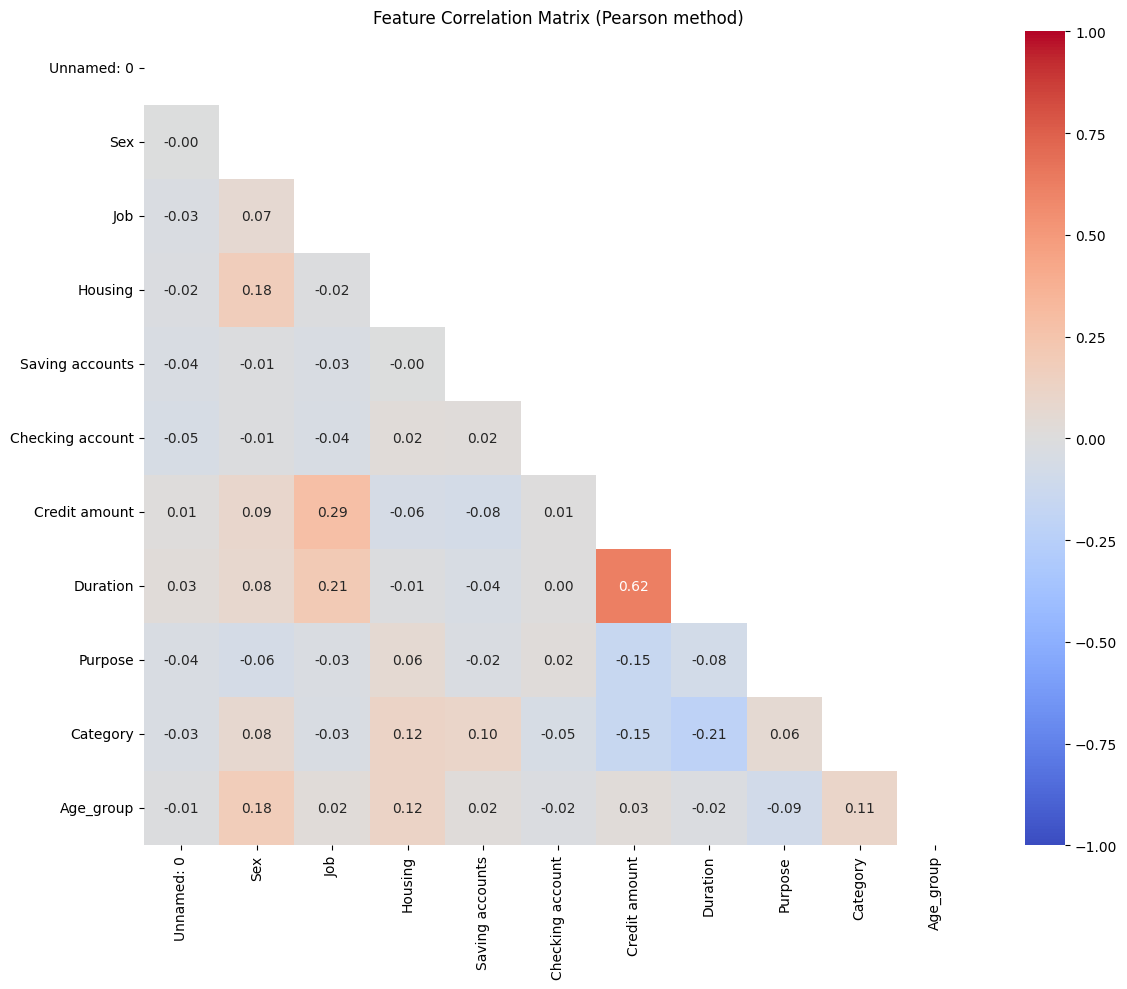

Identified proxy features: {'Age_group': ['Sex', 'Category', 'Housing']}


In [6]:
pp.correlation_matrix(df_enc)
proxy_dict = pp.identify_proxy_variables(df_enc, sensitive_attrs=[sensitive_col_group], method='relative')
print("Identified proxy features:", proxy_dict)

### Proxy Feature Plots

After identifying potential proxy feature, their correlation to the sensitive variable, `Age_group`, will be verified. An examination of the distributions for `Sex` and `Housing` reveals that they are not skewed and likely do not encode information related to `Age_group`. There is no clear trend for either feature with age, with aligns with practical expectation; sex and housing are largely not correlated with age.

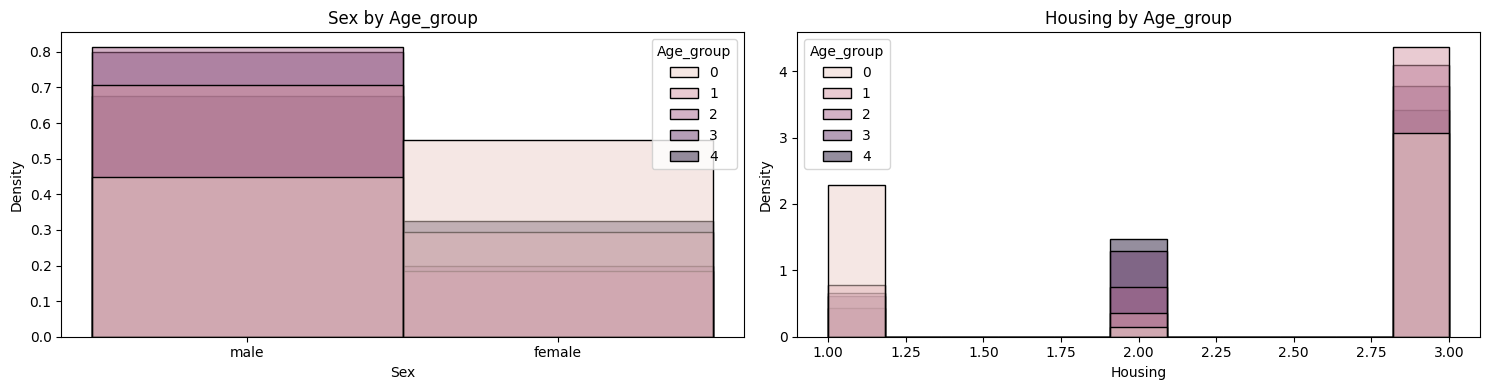

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

for ax, col in zip(axes, ['Sex', 'Housing']):
    sns.histplot(data=df, x=col, hue=sensitive_col_group, kde=False, ax=ax, stat="density", common_norm=False)
    ax.set_title(f"{col} by {sensitive_col_group}")

plt.tight_layout(); plt.show()

### Proxy Modeling

Proxy modeling involves training a predictive model to determine whether certain features can be used to infer a sensitive attribute. If the model achieves high accuracy and ROC-AUC, it suggests that these features encode information about the sensitive attribute, even if indirectly.

Proxy modeling is a strong indicator of potential bias. In this scenario, a logistic regression model is used to predict `Age_group` with only `Sex` and `Housing`. Since `Age_group` is an ordinal variable with 5 categories, random guessing would yield an expected accuracy of ~20% and AUC of ~0.5. The model achieved an accuracy of 43.5% and AUC of 0.599, indicating that these features carry some information about the sensitive attribute. However, this signal is relatively weak and does not by itself demonstrate that `Sex` or `Housing` are strong proxies for age.

In [8]:
proxy_features = ['Sex', 'Housing']

df_proxy =  df_enc[proxy_features + [sensitive_col_group]]

X_proxy = df_proxy[proxy_features]
y_proxy = df_proxy[sensitive_col_group]
X_train_proxy, X_test_proxy, y_train_proxy, y_test_proxy = train_test_split(X_proxy, y_proxy, test_size=0.2, random_state=42)

proxy_model = LogisticRegression(max_iter=1000, random_state=42)
proxy_model.fit(X_train_proxy, y_train_proxy)

y_pred_proxy = proxy_model.predict(X_test_proxy)
y_pred_proba = proxy_model.predict_proba(X_test_proxy)
print(f"Proxy Model Accuracy: {accuracy_score(y_test_proxy, y_pred_proxy):.3f}")
print(f"Proxy Model AUC: {roc_auc_score(y_test_proxy, y_pred_proba, multi_class='ovr'):.3f}")

Proxy Model Accuracy: 0.435
Proxy Model AUC: 0.599


## Baseline Model

To establish a performance benchmark, a baseline supervised classifier is trained using all features, including sensitive attribute `Age_group`. The baseline quantifies the model’s unconstrained behavior and exposes any initial disparities. These baseline numbers define the reference point for measuring the effect of later mitigation strategies.

In [9]:
baseline_model = LogisticRegression(max_iter=1000, random_state=42)
baseline_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

### Baseline Accuracy Evaluation

After training the baseline logistic regression model, its performance is evaluated using accuracy and ROC AUC. Accuracy measures the proportion of correct predictions, while ROC AUC reflects the model's ability to distinguish between classes across different thresholds.

The baseline model achieves an accuracy of 71.5% and a moderate ROC AUC of 0.648, which is consistent with typical performance benchmarks for the German Credit Data dataset. While these results reflect solid predictive ability under traditional evaluation, they do not account for fairness, so group-level disparities may be present.

In [10]:
y_pred = baseline_model.predict(X_test)
y_probs = baseline_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_probs)

print("=== Baseline Model ===")
print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC: {auc:.3f}")

=== Baseline Model ===
Accuracy: 0.715
ROC AUC: 0.648


### Baseline Fairness Evaluation

To assess fairness in the baseline model, equalized odds across groups defined by the sensitive attribute `age` is examined. Equalized odds considers both true positive rate (TPR) and false positive rate (FPR) differences; in this case, it captures whether groups are treated similarly in terms of correct approvals and mistaken approvals. Using `MetricFrame`, TPR and FPR are computed separately for each group to visualize the disparity.

This result reveals a notable disparity: an equalized odds ratio of 0.69 indicates substantial disparities across age groups. For example, younger applicants (`18-25`) achieve a TPR of 0.95 but have an FPR of 0.63, while middle-aged groups (`36-45` and `46-55`) maintain near-perfect TPRs but higher FPRs (0.91 and 0.83). Older applicants (`55+`) are always approved when truly creditworthy (TPR = 1.0) but still face non-trivial false approvals (FPR = 0.75). These results reveal that while predictive performance appears strong in aggregate, error rates are unevenly distributed across age groups, with younger and older applicants experiencing different balances of mistaken denials and mistaken approvals. Such disparities can create fairness risks in credit allocation if left unmitigated.

Equalized odds ratio: 0.69
Baseline Equalized Odds Ratio by age group:


,True Positive Rate,False Positive Rate
Age_group,,
18-25,0.954545,0.625000
26-35,0.928571,0.875000
36-45,0.911765,0.909091
46-55,1.000000,0.833333
55+,1.000000,0.750000


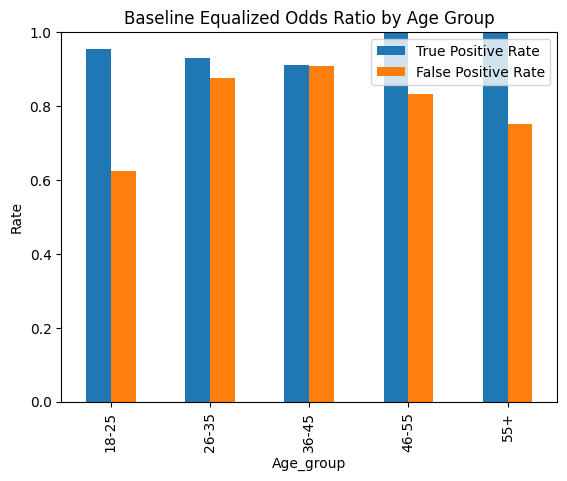

In [11]:
eod_ratio_base = equalized_odds_ratio(y_test, y_pred, sensitive_features=g_test)
print(f"Equalized odds ratio: {eod_ratio_base:.2f}")

mf_base = MetricFrame(
    metrics={'True Positive Rate': true_positive_rate, 'False Positive Rate': false_positive_rate},
    y_true=y_test, y_pred=y_pred,
    sensitive_features=g_test.replace({0:'18-25', 1:'26-35', 2:'36-45', 3:'46-55', 4:'55+'})
)
print("Baseline Equalized Odds Ratio by age group:")
display(mf_base.by_group)

mf_base.by_group.plot(kind='bar')
plt.ylabel('Rate'); plt.title('Baseline Equalized Odds Ratio by Age Group'); plt.ylim(0, 1); plt.show()

## Correlation Remover Model

Most simple bias mitigation techniques only involve removing the sensitive attribute, but more steps are often needed to address indirect bias introduced through proxy features. Correlation removal is a preprocessing fairness technique that works by eliminating correlations between the sensitive attribute and the rest of the dataset to remove indirect encoders of bias. In this case, a `CorrelationRemover` transforms the original dataset to remove correlations with sensitive feature `Age_group`, with `alpha=0.2` indicating that 20% of the correlation is removed. Then, a simple model is fitted to the altered dataset.

In [12]:
cr = CorrelationRemover(sensitive_feature_ids=[sensitive_col_group], alpha=0.2)
X_features = X.drop(sensitive_col_group, axis=1)
X_transformed = pd.DataFrame(cr.fit_transform(X), columns=X_features.columns, index=X_features.index)

X_train_debiased, X_test_debiased, y_train_debiased, y_test_debiased, g_train_debiased, g_test_debiased = train_test_split(
    X_transformed, y, g,
    test_size=0.2, random_state=42, stratify=stratify_labels
)

debiased_model = LogisticRegression(max_iter=1000, random_state=42)
debiased_model.fit(X_train_debiased, y_train_debiased)

LogisticRegression(max_iter=1000, random_state=42)

### Correlation Remover Accuracy Evaluation

After training a logistic regression model on the debiased dataset, its performance is evaluated. These results show a miniscule decrease in performance (71.5% accuracy, 0.638 ROC AUC) compared to the previous model, suggesting that the model retains a good portion of its predictive performance even after fairness interventions.

This trade-off is often acceptable in fairness-aware modeling, especially when it leads to reduced bias and more equitable outcomes across sensitive groups.

In [13]:
y_pred_deb = debiased_model.predict(X_test_debiased)
y_probs_deb = debiased_model.predict_proba(X_test_debiased)[:, 1]

acc_deb = accuracy_score(y_test_debiased, y_pred_deb)
auc_deb = roc_auc_score(y_test_debiased, y_probs_deb)

print("=== Correlation Remover Model ===")
print(f"Accuracy: {acc_deb:.3f}")
print(f"ROC AUC: {auc_deb:.3f}")

=== Correlation Remover Model ===
Accuracy: 0.715
ROC AUC: 0.638


### Correlation Remover Fairness Evaluation

After removing sensitive correlations, the selection rate across groups defined by the sensitive attribute `Age_group` is examined. In this case, equalized odds captures whether groups are treated similarly in terms of correct approvals and mistaken approvals.

After removing sensitive correlations with `Age_group`, the equalized odds ratio improves from 0.69 in the baseline to a ratio of 0.73, indicating more balanced treatment across age groups. For example, all groups maintain high TPR (≥90%) while the youngest and oldest groups (`18-25`, `46-55`, `55+`) experience disparities in FPR. Overall, the model narrows disparities in error rates across age groups, making outcomes fairer than the baseline.

Equalized odds ratio: 0.73
Correlation Remover Equalized Odds Ratio by age group:


,True Positive Rate,False Positive Rate
Age_group,,
18-25,0.954545,0.687500
26-35,0.928571,0.875000
36-45,0.911765,0.909091
46-55,1.000000,0.666667
55+,1.000000,0.750000


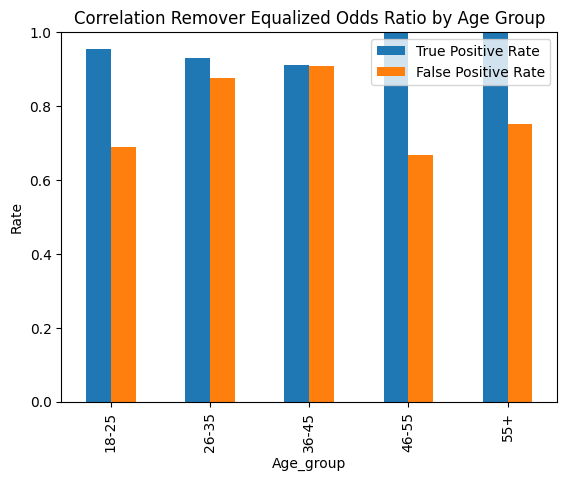

In [14]:
eod_ratio_deb = equalized_odds_ratio(y_test_debiased, y_pred_deb, sensitive_features=g_test_debiased)
print(f"Equalized odds ratio: {eod_ratio_deb:.2f}")

mf_deb = MetricFrame(
    metrics={'True Positive Rate': true_positive_rate, 'False Positive Rate': false_positive_rate},
    y_true=y_test_debiased, y_pred=y_pred_deb,
    sensitive_features=g_test_debiased.replace({0:'18-25', 1:'26-35', 2:'36-45', 3:'46-55', 4:'55+'})
)
print("Correlation Remover Equalized Odds Ratio by age group:")
display(mf_deb.by_group)

mf_deb.by_group.plot(kind='bar')
plt.ylabel('Rate'); plt.title('Correlation Remover Equalized Odds Ratio by Age Group'); plt.ylim(0, 1); plt.show()

## Exponentiated Gradient Model

To further mitigate bias, `ExponentiatedGradient` algorithm with a `EqualizedOdds` constraint. This method adjusts the model’s predictions to ensure that the TPR and FPR are approximately equal across sensitive groups (in this case, age), while still aiming to preserve predictive performance.

In [15]:
exg_estimator = LogisticRegression(max_iter=1000, random_state=42)
exg = ExponentiatedGradient(estimator=exg_estimator,
                           constraints=EqualizedOdds(),
                           eps=0.001)

exg.fit(X_train_debiased, y_train_debiased, sensitive_features=g_train_debiased)

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.EqualizedOdds object at 0x00000193D6079610>,
                      eps=0.001,
                      estimator=LogisticRegression(max_iter=1000,
                                                   random_state=42),
                      nu=0.008005859673476)

### Exponentiated Gradient Accuracy Evaluation

Exponentiated gradient is combined with proxy debiasing, and a new logistic regression model is evaluated. These results show a drop in performance (71.0% accuracy, 0.571 ROC AUC) reflecting the typical trade-off between predictive performance and fairness when fairness constraints are applied.

This trade-off clearly shows the cost of enforcing stronger fairness constraints, as practical application requires carefully balancing equity objectives with predictive performance.

In [16]:
pmf = exg._pmf_predict(X_test_debiased)
y_prob_exg = pmf @ np.array([0, 1])
y_pred_exg = (y_prob_exg >= 0.5).astype(int)

acc_exg = accuracy_score(y_test_debiased, y_pred_exg)
auc_exg = roc_auc_score(y_test_debiased, y_prob_exg)

print("=== Exponentiated Gradient Model ===")
print(f"Accuracy: {acc_exg:.3f}")
print(f"ROC AUC: {auc_exg:.3f}")

=== Exponentiated Gradient Model ===
Accuracy: 0.710
ROC AUC: 0.571


### Exponentiated Gradient Model Fairness Evaluation

After training the new model, fairness is accessed by measuring equalized odds across age groups. In this case, equalized odds captures whether groups are treated similarly in terms of correct approvals and mistaken approvals.

After applying exponentiated gradient, the equalized odds ratio does not change from the correlation remover model, remaining at 0.73. At the same time, the FPR stays the same while TPR becomes slightly worse. Since equalized odds depends on the balance of true and false positive rates across groups, the unchanged FPR and slightly degraded TPR indicate that the model converged to a solution similar to the preprocessed data, but with added cost to classification performance. In practice, this can happen when the fairness constraint is already largely satisfied by preprocessing, leaving limited room for the in-processing method to improve equity further.

Equalized odds ratio: 0.73
Exponentiated Gradient Equalized Odds Ratio by age group:


,True Positive Rate,False Positive Rate
Age_group,,
18-25,0.954545,0.687500
26-35,0.928571,0.875000
36-45,0.882353,0.909091
46-55,1.000000,0.666667
55+,1.000000,0.750000


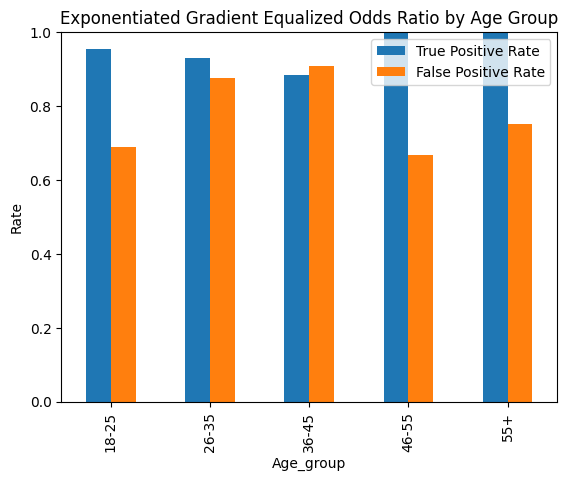

In [17]:
eod_ratio_exg = equalized_odds_ratio(y_test_debiased, y_pred_exg, sensitive_features=g_test_debiased)
print(f"Equalized odds ratio: {eod_ratio_exg:.2f}")

mf_exg = MetricFrame(
    metrics={'True Positive Rate': true_positive_rate, 'False Positive Rate': false_positive_rate},
    y_true=y_test_debiased, y_pred=y_pred_exg,
    sensitive_features=g_test_debiased.replace({0:'18-25', 1:'26-35', 2:'36-45', 3:'46-55', 4:'55+'})
)
print("Exponentiated Gradient Equalized Odds Ratio by age group:")
display(mf_exg.by_group)

mf_exg.by_group.plot(kind='bar')
plt.ylabel('Rate'); plt.title('Exponentiated Gradient Equalized Odds Ratio by Age Group'); plt.ylim(0, 1); plt.show()

## Threshold Optimizer Model

Another technique for addressing fairness disparities is threshold optimization, which adjusts the decision thresholds of a previously biased model to satisfy a fairness constraint. In this case, the initial baseline model is retrained and further refined using the `ThresholdOptimizer` with an equalized odds constraint. This approach modifies the decision thresholds for different sensitive groups, ensuring that TPR and FPR are more evenly distributed across groups (in this case, age), while still maintaining overall predictive performance.

In [18]:
thresh_estimator = LogisticRegression(max_iter=1000, random_state=42)
thresh = ThresholdOptimizer(
    estimator=thresh_estimator,
    constraints="equalized_odds",
    prefit=False,
    predict_method='predict_proba'
)
thresh.fit(X_train.drop(columns=[sensitive_col_group], axis=1), y_train, sensitive_features=g_train)

ThresholdOptimizer(constraints='equalized_odds',
                   estimator=LogisticRegression(max_iter=1000, random_state=42),
                   predict_method='predict_proba')

### Threshold Optimizer Model Accuracy Evaluation

Threshold optimization is used on the baseline model and evaluated for performance. These results show a significant decrease in performance (68.5% accuracy, 0.567 ROC AUC) compared to the baseline model, indicating that while fairness is improved across groups, there is a great loss in discriminative power.

This trade-off clearly shows the cost of enforcing stronger fairness constraints, as practical application requires carefully balancing equity objectives with predictive performance.

In [19]:
y_pred_thr = thresh.predict(X_test.drop(columns=[sensitive_col_group], axis=1), sensitive_features=g_test, random_state=42)
y_prob_thr = thresh._pmf_predict(X_test.drop(columns=[sensitive_col_group], axis=1), sensitive_features=g_test) @ np.array([0,1])

acc_thr = accuracy_score(y_test, y_pred_thr)
auc_thr = roc_auc_score(y_test, y_prob_thr)

print("=== Threshold Optimizer Model ===")
print(f"Accuracy: {acc_thr:.3f}")
print(f"ROC AUC: {auc_thr:.3f}")

=== Threshold Optimizer Model ===
Accuracy: 0.685
ROC AUC: 0.567


### Threshold Optimizer Model Fairness Evaluation

After training the new model, fairness is accessed by measuring equalized odds across age groups. In this case, equalized odds captures whether groups are treated similarly in terms of correct approvals and mistaken approvals.

Compared to the baseline, threshold optimizing delivers the strongest improvement: the equalized odds ratio increases from 0.69 in the baseline to 0.83, signaling more consistent treatment across age groups. TPR remains uniformly high across groups (≥0.85), while FPR becomes more closely aligned across groups (~0.75-0.90) compared to the baseline. This model represents a balanced trade-off, preserving much of the predictive accuracy of the baseline while achieving substantially fairer outcomes across age groups.

Equalized odds ratio: 0.83
Threshold Optimizer Equalized Odds Ratio by age group:


,True Positive Rate,False Positive Rate
Age_group,,
18-25,0.954545,0.875000
26-35,0.928571,0.875000
36-45,0.852941,0.909091
46-55,1.000000,0.833333
55+,1.000000,0.750000


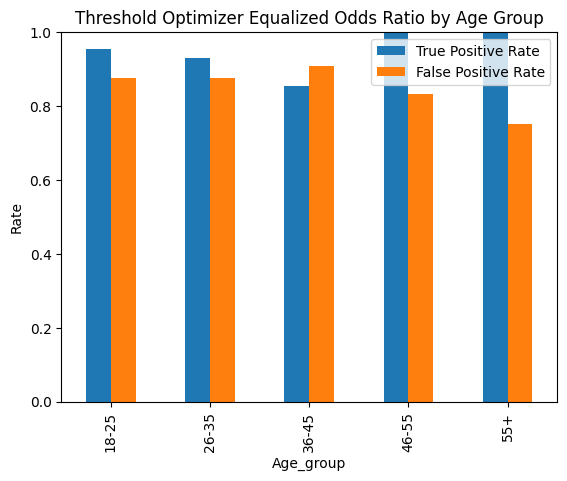

In [20]:
eod_ratio_thr = equalized_odds_ratio(y_test, y_pred_thr, sensitive_features=g_test)
print(f"Equalized odds ratio: {eod_ratio_thr:.2f}")

mf_thr = MetricFrame(
    metrics={'True Positive Rate': true_positive_rate, 'False Positive Rate': false_positive_rate},
    y_true=y_test, y_pred=y_pred_thr,
    sensitive_features=g_test.replace({0:'18-25', 1:'26-35', 2:'36-45', 3:'46-55', 4:'55+'})
)
print("Threshold Optimizer Equalized Odds Ratio by age group:")
display(mf_thr.by_group)

mf_thr.by_group.plot(kind='bar')
plt.ylabel('Rate'); plt.title('Threshold Optimizer Equalized Odds Ratio by Age Group'); plt.ylim(0, 1); plt.show()

## Model Evaluation

To evaluate the overall impact of fairness interventions, models are compared on three key dimensions: accuracy, ROC AUC, and equalized odds by age group. From the histogram plots, the relative differences across approaches are exposed.

Taken together, theses results reveal that in fair lending contexts where regulatory compliance is critical, post-processing adjustments may provide a practical trade-off: preserving accuracy while reducing age-related disparities in credit decisions. While threshold optmization introduces the sharpest performance decline, it still achieves the strongest fairness improvement.

### Accuracy Rate Plots

The baseline and correlation removal achieve an accuracy of 71.5%. Exponentiated gradient reduces performance slightly to 71.0%, while threshold optimization further reduces accuracy to 68.5%. This suggests that post-processing constraints impose a stronger cost on predictive performance than preprocessing adjustment.

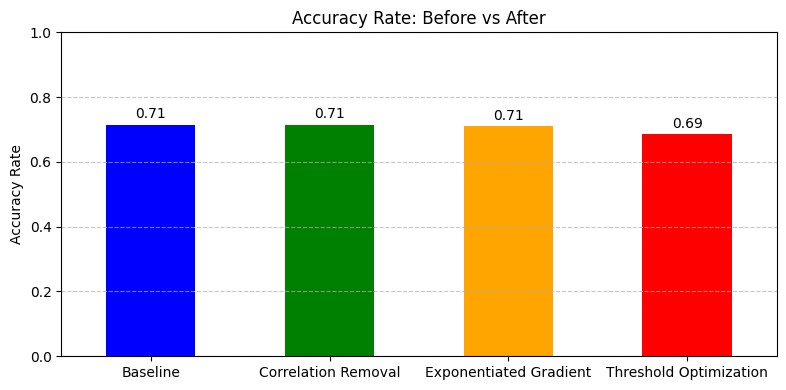

In [21]:
accuracy_comparison = pd.DataFrame({
    'Accuracy Rate': [acc, acc_deb, acc_exg, acc_thr]
}, index=['Baseline', 'Correlation Removal', 'Exponentiated Gradient', 'Threshold Optimization'])

colors = ['blue', 'green', 'orange', 'red']
accuracy_series = accuracy_comparison['Accuracy Rate']

ax = accuracy_series.plot(kind='bar', figsize=(8, 4), color=colors)
plt.ylabel('Accuracy Rate'); plt.title('Accuracy Rate: Before vs After'); plt.ylim(0, 1); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.xticks(rotation=0)

for i, val in enumerate(accuracy_series):
    ax.text(i, val + 0.01, f'{val:.2f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

### ROC AUC Plots

The baseline model reaches an AUC of 0.648, reflecting moderate discriminative ability. All fairness interventions lower this substantially: correlation removal lowers AUC to 0.638, exponentiated gradient falls to 0.571, and threshold optimization still trails the baseline at 0.567. These results highlight that fairness constraints reduce the model’s ability to rank applicants by credit risk.

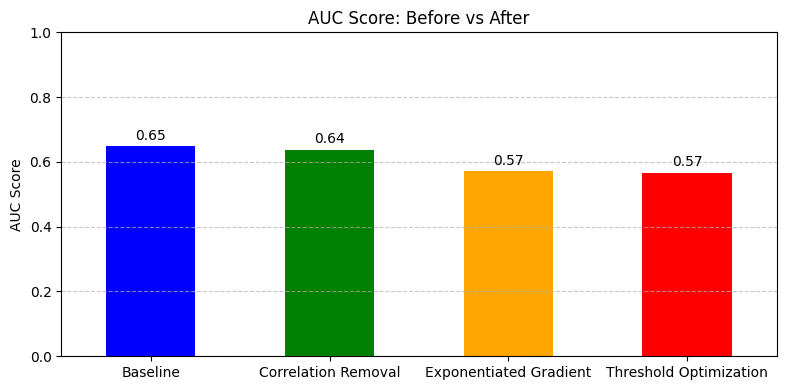

In [22]:
auc_comparison = pd.DataFrame({
    'AUC Rate': [auc, auc_deb, auc_exg, auc_thr]
}, index=['Baseline', 'Correlation Removal', 'Exponentiated Gradient', 'Threshold Optimization'])

colors = ['blue', 'green', 'orange', 'red']
auc_series = auc_comparison['AUC Rate']

ax = auc_series.plot(kind='bar', figsize=(8, 4), color=colors)
plt.ylabel('AUC Score'); plt.title('AUC Score: Before vs After'); plt.ylim(0, 1); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.xticks(rotation=0)

for i, val in enumerate(auc_series):
    ax.text(i, val + 0.01, f'{val:.2f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

### Equalized Odds Plots

The baseline model exhibits high variability across age groups. Younger applicants (`18–25`) face much lower FPR (0.625) than older groups (0.750 for `55+`), and TPR also differs by age. Exponentiated gradient reduces some disparities but at the expense of performance, while threshold optimization achieves the highest equalized odds ratio (0.83) compared to the baseline (0.69) and correlation removal / exponentiated gradient (0.73). This reveals that post-processing adjustment is the most effective at achieving equalized odds across groups.

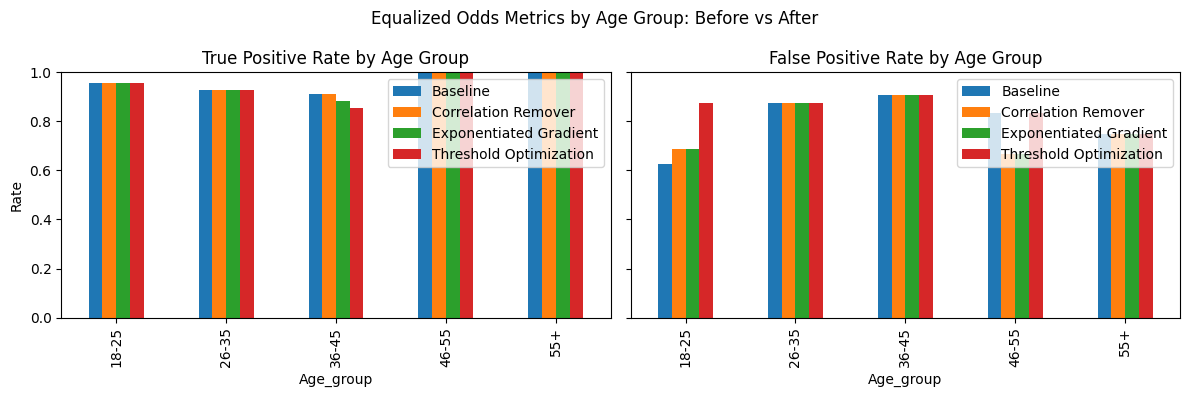

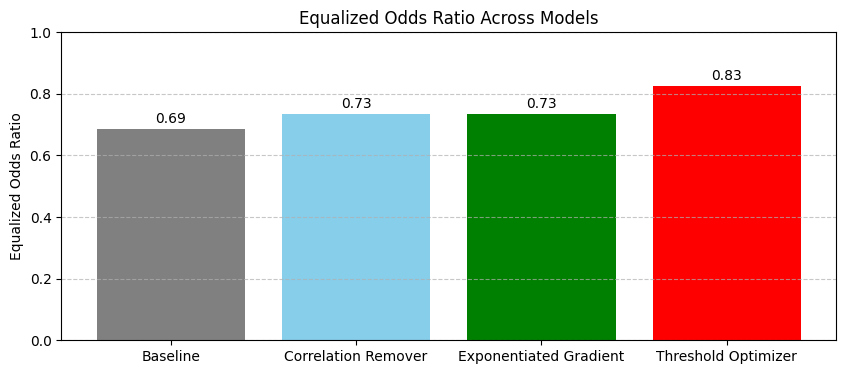

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)

tpr_fairness_comparison = pd.DataFrame({
    'Baseline': mf_base.by_group['True Positive Rate'],
    'Correlation Remover': mf_deb.by_group['True Positive Rate'],
    'Exponentiated Gradient': mf_exg.by_group['True Positive Rate'],
    'Threshold Optimization': mf_thr.by_group['True Positive Rate']
})
tpr_fairness_comparison.plot(kind='bar', ax=axes[0])
axes[0].set_title('True Positive Rate by Age Group'); axes[0].set_ylabel('Rate'); axes[0].set_ylim(0, 1)

fpr_fairness_comparison = pd.DataFrame({
    'Baseline': mf_base.by_group['False Positive Rate'],
    'Correlation Remover': mf_deb.by_group['False Positive Rate'],
    'Exponentiated Gradient': mf_exg.by_group['False Positive Rate'],
    'Threshold Optimization': mf_thr.by_group['False Positive Rate']
})
fpr_fairness_comparison.plot(kind='bar', ax=axes[1])
axes[1].set_title('False Positive Rate by Age Group'); axes[1].set_ylim(0, 1)

plt.suptitle('Equalized Odds Metrics by Age Group: Before vs After')
plt.tight_layout()
plt.show()

eod_ratio_comparison = {
    'Baseline': eod_ratio_base,
    'Correlation Remover': eod_ratio_deb,
    'Exponentiated Gradient': eod_ratio_exg,
    'Threshold Optimizer': eod_ratio_thr
}

plt.figure(figsize=(10,4))
plt.bar(eod_ratio_comparison.keys(), eod_ratio_comparison.values(), color=['gray', 'skyblue', 'green', 'red'])
plt.ylim(0, 1)
plt.ylabel("Equalized Odds Ratio")
plt.title("Equalized Odds Ratio Across Models")
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, val in enumerate(eod_ratio_comparison.values()):
    plt.text(i, val + 0.01, f'{val:.2f}', ha='center', va='bottom', fontsize=10)

plt.show()

## Takeaways

This notebook demonstrated how fairness interventions can alter both the accuracy and equity of credit scoring models. By comparing exponentiated gradient and threshold optimization, the pipeline showed how different fairness strategies affect predictive performance and group-level error rates. Exponentiated gradient reduced disparities across age groups but introduced a notable decline in both accuracy and ROC AUC. Threshold optimization reduced performance while achieving the strongest improvement in equalized odds.

Fairness does not come without trade-offs: stronger interventions can improve equity but often at the expense of discriminative performance. In financial services, these trade-offs must be weighed carefully. A model that reduces disparities via equalized odds helps ensure that younger applicants are not unjustly denied credit and older applicants are not over-favored. By situating fairness metrics alongside traditional performance measures, this workflow shows how practitioners can design lending systems that are accurate, equitable, and compliant with fair lending principles.